## Calculate node and edge statistics

In this script, we want to look in more detail at some of the graph attributes that might separate generic genes from non-generic genes. We'll look at:

* node (gene) degree in the eADAGE graph
* edge weight in the eADAGE graph
* [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) of generic vs. non-generic genes
* [PageRank](https://en.wikipedia.org/wiki/PageRank) (sometimes called PageRank centrality) of generic vs. non-generic genes, specifically the [undirected version](https://en.wikipedia.org/wiki/PageRank#PageRank_of_an_undirected_graph).

In [1]:
import os

import numpy as np
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt
import seaborn as sns

gt.seed_rng(1)
np.random.seed(1)

In [2]:
# relevant file paths
data_dir = './data'
processed_graph = os.path.join(data_dir, 'eadage_generic_graph_unsigned.gt')

In [3]:
G = gt.load_graph(processed_graph)
# make sure vertex/edge properties exist
print(G)
print(list(G.vp.keys()))
print(list(G.ep.keys()))

<Graph object, undirected, with 3477 vertices and 31556 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f57f2557a30>
['name', 'is_generic']
['weight']


### Plot degree distribution + look at degrees of generic genes

In [4]:
vs = G.get_vertices()
names = [G.vp['name'][v] for v in vs]
is_generic = [G.vp['is_generic'][v] for v in vs]
degrees = G.get_total_degrees(vs)
degree_df = pd.DataFrame({
    'gene': names,
    'degree': degrees,
    'is_generic': is_generic
})
degree_df.sort_values(by='degree', ascending=False).head()

,gene,degree,is_generic
26,PA4238,209,0
29,PA4245,201,0
30,PA4247,192,0
79,PA4252,181,0
27,PA4239,180,0


Text(0.5, 1.0, 'Degree distribution of generic/non-generic genes')

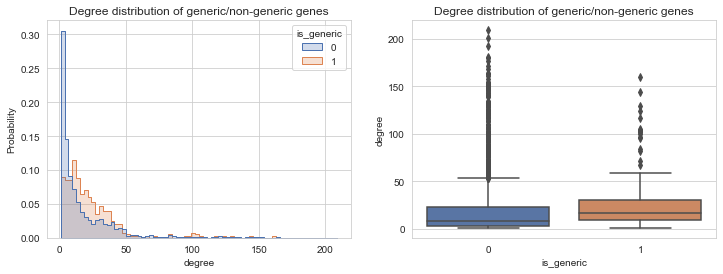

In [5]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=degree_df, x='degree', hue='is_generic', element='step',
             stat='probability', common_norm=False, ax=axarr[0])
axarr[0].set_title('Degree distribution of generic/non-generic genes')
sns.boxplot(data=degree_df, y='degree', x='is_generic', ax=axarr[1])
axarr[1].set_title('Degree distribution of generic/non-generic genes')

### Plot weight distribution + look at weights of edges connecting generic genes

There are 3 possible types of edges:
* an edge connects 2 generic genes
* an edge connects 2 non-generic genes
* an edge connects a generic gene with a non-generic gene

We'll look separately at the edge weight distribution for each of these edge types.

In [6]:
# plot weight distribution + look at weights of edges including generic genes
# (v1, v2, weight, is_generic)
edges = []
for s, t, w in G.iter_edges([G.ep['weight']]):
    if (G.vp['is_generic'][s]) and (G.vp['is_generic'][t]):
        is_generic = 2
    elif (G.vp['is_generic'][s]) or (G.vp['is_generic'][t]):
        is_generic = 1
    else:
        is_generic = 0
    edges.append((G.vp['name'][s], G.vp['name'][t], w, is_generic))
weight_df = pd.DataFrame(edges, columns=['g1', 'g2', 'weight', 'is_generic'])
print(weight_df.shape)
weight_df.head()

(31556, 4)


,g1,g2,weight,is_generic
0,PA0001,PA0002,0.578872,0
1,PA0001,PA0548,0.510323,0
2,PA0001,PA0963,0.561494,0
3,PA0001,PA3637,0.512365,0
4,PA0001,PA5554,0.554768,1


Text(0.5, 1.0, 'Weight distribution of generic/non-generic edges')

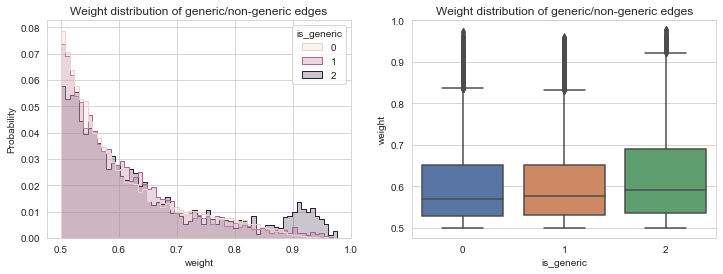

In [7]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=weight_df, x='weight', hue='is_generic', element='step',
             stat='probability', common_norm=False, ax=axarr[0])
axarr[0].set_title('Weight distribution of generic/non-generic edges')
sns.boxplot(data=weight_df, y='weight', x='is_generic', ax=axarr[1])
axarr[1].set_title('Weight distribution of generic/non-generic edges')

### Plot distributions for centrality measures (betweenness + PageRank)

Note that the weighted betweenness centrality calculation interprets edge weights as "costs" (lower = better), so we need to change our correlation-based edge weights to a weight representing dissimilarity or distancs.

PageRank interprets edge weights as "importance scores", so our correlations work fine without any additional transformation.

In [8]:
# add distance = 1 - edge weight to graph as edge property
#
# betweenness centrality is evaluated based on shortest paths in the network,
# but since our edge weights represent similarity, we need to convert them to
# a distance/cost measure
# 
# taking distance = (1 - similarity) is a simple way to do this:
# a high similarity between genes will have a short distance
eprop_distance = G.new_edge_property('float')
for e in G.edges():
    eprop_distance[e] = 1 - G.ep['weight'][e]
G.ep['distance'] = eprop_distance
print(list(G.ep.keys()))

['weight', 'distance']


In [9]:
# analyze betweenness centrality for generic vs. other genes
def betweenness_to_df(G, v_bw):
    vs = G.get_vertices()
    return pd.DataFrame({
        'gene': [G.vp['name'][v] for v in vs],
        'betweenness': [v_bw[v] for v in vs],
        'is_generic': [G.vp['is_generic'][v] for v in vs]
    })

v_bw, _ = gt.betweenness(G, weight=G.ep['distance'])
bw_df = betweenness_to_df(G, v_bw)
bw_df.head()

,gene,betweenness,is_generic
0,PA0001,1.655752e-07,0
1,PA0002,1.056205e-03,0
2,PA0548,9.454347e-05,0
3,PA0963,1.887558e-05,0
4,PA3637,4.420859e-05,0


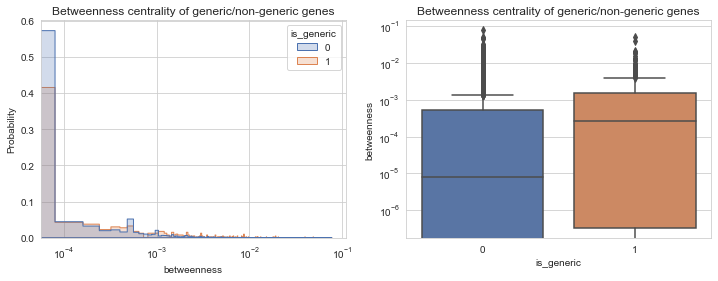

In [10]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=bw_df, x='betweenness', hue='is_generic', element='step',
             stat='probability', common_norm=False, ax=axarr[0])
axarr[0].set_title('Betweenness centrality of generic/non-generic genes')
axarr[0].set_xscale('log')
sns.boxplot(data=bw_df, y='betweenness', x='is_generic', ax=axarr[1])
axarr[1].set_title('Betweenness centrality of generic/non-generic genes')
axarr[1].set_yscale('log')

In [11]:
# analyze pagerank centrality for generic vs. other genes
# pagerank treats edge weights as "importance"/"confidence" rather than cost,
# so we can use the original correlations as edge weights here
pr = gt.pagerank(G, weight=G.ep['weight'])
pr_df = (
    betweenness_to_df(G, pr)
        .rename(columns={'betweenness': 'pagerank'})
)
pr_df.head()

,gene,pagerank,is_generic
0,PA0001,0.000089,0
1,PA0002,0.000399,0
2,PA0548,0.000358,0
3,PA0963,0.000301,0
4,PA3637,0.000530,0


Text(0.5, 1.0, 'PageRank of generic/non-generic genes')

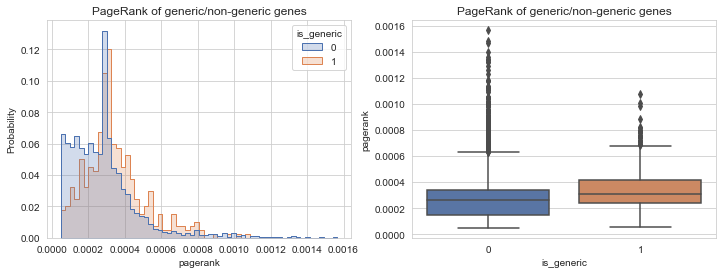

In [12]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=pr_df, x='pagerank', hue='is_generic', element='step',
             stat='probability', common_norm=False, ax=axarr[0])
axarr[0].set_title('PageRank of generic/non-generic genes')
sns.boxplot(data=pr_df, y='pagerank', x='is_generic', ax=axarr[1])
axarr[1].set_title('PageRank of generic/non-generic genes')